In [1]:
#LIBRARIES
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from datetime import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import random
import nibabel as nib
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.data import Dataset, CacheDataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import (
    AsDiscrete,
    Compose,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    CropForegroundd,
)
from monai.networks.nets import SwinUNETR
import segmentation_models_pytorch as smp
import functions
import loaddata
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import transforms2

# Initialize TensorBoard
writer = SummaryWriter()
torch.cuda.empty_cache()

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#print_config()

experiment = "s3"
experiment_dir = f"/home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/{experiment}"
json_path = f"{experiment_dir}/hyperparameters.json"

if os.path.exists(json_path):
    with open(json_path, "r") as f:
        hyperparams = json.load(f)

# Functions to get additional parameters
lossfunc = functions.get_loss_func(hyperparams["diceCE"])
label_names, numberofclasses = functions.get_classes(hyperparams["dataset"], hyperparams["seg"])
dimension, batchsize = functions.get_dimension_and_bs(hyperparams["dataset"])
dice_roi, aug_roi = functions.get_rois(hyperparams["dataset"], hyperparams["architecture"])


# Update hyperparameters
hyperparams.update({
    "experiment": experiment,
    "number_of_classes": numberofclasses,
    "dimension": dimension,
    "batch_size": batchsize,
    "dice_roi": dice_roi,
    "aug_roi": aug_roi,
    "date_time": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),  # Log timestamp
    "loss_function": f"{lossfunc} ({hyperparams['wdice']}-{hyperparams['wce']})",
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "patience": 10
})

# Save the updated hyperparameters back to the JSON file
with open(json_path, "w") as f:
    json.dump(hyperparams, f, indent=4)

print("Hyperparameters updated and saved.")

if hyperparams["server"]:
    data_dir = os.path.join("/data/ayc9699/dataset", hyperparams["dataset"])
else:
    data_dir = os.path.join("/home/ilkin/Documents/2024PHD/data", hyperparams["dataset"])


/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
Hyperparameters updated and saved.


In [2]:
fold_splits = loaddata.get_train_val_test_files_5fold_planning(
    dataset=hyperparams["dataset"],
    data_dir=data_dir,
    train_rt=hyperparams["train_rt"], 
    val_rt=hyperparams["val_rt"], 
    test_rt=hyperparams["test_rt"],
    output_dir=experiment_dir,
    seg=hyperparams["seg"],
    modified=False,
    num_folds=hyperparams["num_folds"],
)

train_transforms = transforms2.getTrainTransform(dimension, aug_roi)
val_transforms = transforms2.getValTransform()
test_transforms = transforms2.getTestTransform(-175, 250)

Total number of patients: 188
1-Fold Split:
  Training Patients: 152
  Validation Patients: 18
  Test Patients: 18


/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [3]:
def save_nifti(image, mask, output_dir, prefix, index):
    """
    Save image and mask as NIfTI files for debugging.

    Parameters:
        image (numpy array): The image volume to save.
        mask (numpy array): The mask volume to save.
        output_dir (str): Directory where the NIfTI files will be saved.
        prefix (str): Prefix for the filenames.
        index (int): Index of the sample for unique filenames.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    image_nifti = nib.Nifti1Image(image, affine=np.eye(4))
    mask_nifti = nib.Nifti1Image(mask, affine=np.eye(4))

    image_path = os.path.join(output_dir, f"{prefix}_image_{index}.nii.gz")
    mask_path = os.path.join(output_dir, f"{prefix}_mask_{index}.nii.gz")

    nib.save(image_nifti, image_path)
    nib.save(mask_nifti, mask_path)

    print(f"Saved image to: {image_path}")
    print(f"Saved mask to: {mask_path}")

def visualize_and_save_batch(data_files, transform, output_dir, batch_size=4, num_slices=3):
    """
    Visualize images and their corresponding masks from a dataset, and save them as NIfTI files.

    Parameters:
        data_files (list): List of dictionaries with keys 'image' and 'mask'.
        transform (callable): Transformation to apply to the data.
        output_dir (str): Directory where NIfTI files will be saved.
        batch_size (int): Number of samples to visualize.
        num_slices (int): Number of slices to display per volume.
    """
    dataset = Dataset(data=data_files[:batch_size], transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for batch_idx, batch in enumerate(data_loader):
        images = batch[0]["image"]
        masks = batch[0]["mask"]

        fig, axes = plt.subplots(batch_size, num_slices, figsize=(15, 5))
        for i in range(batch_size):
            image_np = images[i].squeeze().cpu().numpy()
            mask_np = masks[i].squeeze().cpu().numpy()
            print(image_np.unique)

            # Save image and mask as NIfTI files
            save_nifti(image_np, mask_np, output_dir, prefix=f"sample_{batch_idx * batch_size + i}", index=i)

            # Determine slice indices
            slice_indices = np.linspace(0, image_np.shape[-1] - 1, num_slices, dtype=int)

            for j, slice_idx in enumerate(slice_indices):
                if num_slices > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j]

                ax.imshow(image_np[:, :, slice_idx], cmap="gray")
                ax.imshow(mask_np[:, :, slice_idx], cmap="jet", alpha=0.5)
                ax.axis("off")

        plt.show()
        break  # Show and save only the first batch

# Example usage
fold_idx = 0  # Specify the fold index (0-based)
data="train"

output_dir = os.path.join(experiment_dir, f"fold_{fold_idx + 1}", f"visualizations_{data}")

print(f"Visualizing and saving Fold {fold_idx + 1} Train Data")
visualize_and_save_batch(
    data_files=fold_splits[fold_idx]["train_files"],  # Change to "val_files" or "test_files" as needed
    transform=train_transforms,  # Use appropriate transform (train, val, or test)
    output_dir=output_dir,
    batch_size=2,  # Number of samples to visualize
    num_slices=3    # Number of slices per volume to visualize
)

Visualizing and saving Fold 1 Train Data


KeyboardInterrupt: 

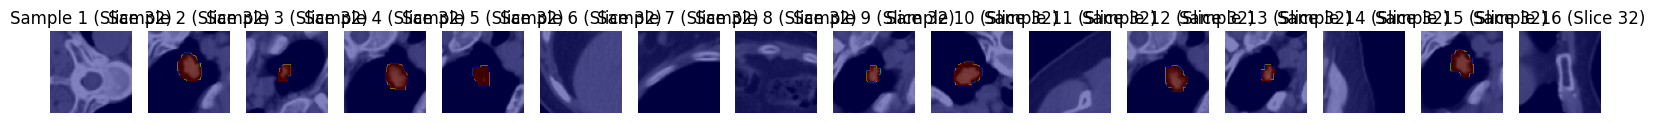

In [6]:
fold_idx=0

train_dataset = Dataset(data=fold_splits[fold_idx]["train_files"], transform=train_transforms)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

# Define a function to visualize a batch of images with segmentation masks
def visualize_batch_with_masks(batch_data):
    fig, axes = plt.subplots(1, len(batch_data), figsize=(20, 5))

    for i, sample_data in enumerate(batch_data):
        sample_image = sample_data["image"]
        sample_mask = sample_data["mask"]

        # Convert image and mask to numpy array
        image_np = sample_image.squeeze().cpu().numpy()
        mask_np = sample_mask.squeeze().cpu().numpy()
        #print(np.unique(image_np))
        #print("image uniq", np.unique(image_np))
        #print("mask uq", np.unique(mask_np))


        # Check if the image and mask are 3D
        if len(image_np.shape) == 3:
            # Calculate the middle slice index
            slice_idx = image_np.shape[2] // 2

            # Plot the middle slice of the image
            axes[i].imshow(image_np[:, :, slice_idx], cmap="gray")

            # Overlay the middle slice of the mask
            axes[i].imshow(mask_np[:, :, slice_idx], cmap="jet", alpha=0.5)
            #axes[i].imshow(mask_np[:, :, slice_idx], cmap="cool", alpha=0.5)

            axes[i].set_title(f'Sample {i+1} (Slice {slice_idx})')
        else:
            axes[i].imshow(image_np, cmap="gray")
            axes[i].imshow(mask_np, cmap="cool", alpha=0.5)
            axes[i].set_title(f'Sample {i+1}')

        axes[i].axis('off')

    plt.show()
# Assuming train_loader is your DataLoader with the transformed dataset
for batch_data in train_data_loader:
    visualize_batch_with_masks(batch_data)
    break  # Visualize only the first batch


In [3]:
#VALIDATION AND TRAINING FUNCTIONS

def validation(epoch_iterator_val):
    model.eval()
    meandiceperclass = np.zeros([numberofclasses+1])
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["mask"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, aug_roi, 4, model, overlap=0.5)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dm = dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
            meandiceperclass = meandiceperclass + dm[0]

        print(len(epoch_iterator_val))
        meandiceperclass = meandiceperclass/(len(epoch_iterator_val)+1)
        print(meandiceperclass)
        mean_dice_val = dice_metric.aggregate().item()
        print(mean_dice_val)
        
        dice_metric.reset()


    return meandiceperclass, mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best, patience, max_iterations, fold_dir):
    model.train()
    epoch_loss = 0
    step = 0
    no_improvement_count = 0  # Counter for early stopping
    
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["mask"].cuda())
        
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        # Save checkpoint every 5000 iterations
        if global_step % 5000 == 0:
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "global_step": global_step,
                "dice_val_best": dice_val_best,
            }
            print(fold_dir)
            checkpoint_path = os.path.join(fold_dir, f"checkpoint_step_{global_step}.pth")
            torch.save(checkpoint, checkpoint_path)
            print(f"Checkpoint saved at step {global_step} to {checkpoint_path}")

        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        
        if (global_step % hyperparams["eval_num"] == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val_cb, dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            metrics["train_loss"].append(epoch_loss)
            metrics["val_dice"].append(dice_val)
            scheduler.step(dice_val)
            metrics["val_dice_per_class"].append(dice_val_cb)
            writer.add_scalar('Loss/train', epoch_loss, global_step)
            writer.add_scalar('Dice/mean', dice_val, global_step)
            writer.add_scalar('Dice/tumor', dice_val_cb[1], global_step)
            writer.add_scalar('Dice/background', dice_val_cb[0], global_step)
            
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(fold_dir, "best_metric_model.pth" ))
                print("Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
                print(f"Current Dice for Tumor: {dice_val_cb[1]:.4f}, Background: {dice_val_cb[0]:.4f}")
                no_improvement_count = 0  # Reset the counter since there is an improvement
            else:
                print("Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
                print(f"Current Dice for Tumor: {dice_val_cb[1]:.4f}, Background: {dice_val_cb[0]:.4f}")
                no_improvement_count += 1  # Increment the counter for no improvement
            
            # Early stopping condition
            if no_improvement_count >= patience:
                print("Early stopping due to no improvement for {} consecutive epochs.".format(patience))
                return global_step, dice_val_best, global_step_best, True
        
        global_step += 1
    
    return global_step, dice_val_best, global_step_best, False


In [6]:
#uncomment to download the pre-trained weights
#!wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

In [4]:
#DEFINE MODEL 

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=numberofclasses+1,
    feature_size=48,
    use_checkpoint=True,
).to(device)

if hyperparams["pretraining"]:
    try:
        weight = torch.load("./model_swinvit.pt")
        model.load_from(weights=weight)
        print("Using pretrained self-supervied Swin UNETR backbone weights !")
    except FileNotFoundError:
        print("Pretrained weights not found. Training from scratch.")

# Loss, optimizer, scheduler
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=hyperparams["wdice"], lambda_ce=hyperparams["wce"])
optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=10, verbose=True)
scaler = torch.cuda.amp.GradScaler()

# Post-transforms and metrics
post_label = AsDiscrete(to_onehot=numberofclasses + 1)
post_pred = AsDiscrete(argmax=True, to_onehot=numberofclasses + 1)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Assuming `model` is your network instance
def print_model_weights(model):
    for name, param in model.named_parameters():
        print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]}...")  # Shows first 2 weights of each parameter

# Example usage
#print_model_weights(model)


Using pretrained self-supervied Swin UNETR backbone weights !


In [5]:
# Training loop for all folds
for fold_idx, fold_split in enumerate(fold_splits):
    fold_dir = os.path.join(experiment_dir, f"fold_{fold_idx+1}")

    print(f"Starting training for Fold {fold_idx + 1} / {len(fold_splits)}")
    
    # Set up DataLoaders for this fold
    train_loader = DataLoader(
        CacheDataset(data=fold_split["train_files"], transform=train_transforms, cache_rate=0.1, num_workers=4),
        batch_size=batchsize, shuffle=True, num_workers=4
    )
    val_loader = DataLoader(
        CacheDataset(data=fold_split["val_files"], transform=val_transforms, cache_rate=0.1, num_workers=4),
        batch_size=1, num_workers=4
    )
    
    # Reset training state variables for this fold
    global_step, dice_val_best, global_step_best = 0, 0.0, 0
    patience = hyperparams["patience"]  # Adjust as needed
    max_iterations = hyperparams["max_iterations"]
    early_stopping = False
    
    # Metrics for this fold
    metrics = {
        "fold_idx": fold_idx + 1,            # Fold number
        "train_loss": [],                   # List of training losses per epoch
        "val_loss": [],                     # List of validation losses per epoch
        "val_dice": [],                     # Global Dice score across all classes
        "val_dice_per_class": [],           # Per-class Dice scores (e.g., [background, tumor])
        "best_tumor_dice": 0.0,             # Best tumor Dice score
        "best_iteration": 0,                # Iteration where best tumor Dice occurred
        "learning_rate": [],                # Learning rate per epoch
    }

    torch.backends.cudnn.benchmark = True

    while global_step < max_iterations:

        global_step, dice_val_best, global_step_best, early_stopping = train(
            global_step,
            train_loader,
            dice_val_best,
            global_step_best,
            patience,
            max_iterations,
            fold_dir
        )
        # Log current learning rate
        current_lr = optimizer.param_groups[0]["lr"]
        metrics["learning_rate"].append(current_lr)
        
        if early_stopping:
            print(f"Early stopping triggered for Fold {fold_idx + 1} at iteration {global_step}.")
            metrics["early_stopping"] = {
                "iteration": global_step,
                "reason": "No improvement for {} consecutive evaluations.".format(patience),
            }
            break
    
    # Save best model path for this fold
    best_model_path = os.path.join(fold_dir, "best_metric_model.pth")
    print(f"Training completed for Fold {fold_idx + 1}. Best Tumor Dice: {dice_val_best:.4f}")

    # Save the final model as a checkpoint
    final_checkpoint_path = os.path.join(fold_dir, "final_checkpoint_model.pth")
    torch.save(model.state_dict(), final_checkpoint_path)
    print(f"Final checkpoint saved to {final_checkpoint_path}")

    # Log metrics for this fold
    metrics["best_tumor_dice"] = dice_val_best
    metrics["best_iteration"] = global_step_best
    metrics["final_iteration"] = global_step  # Log the final iteration

    metrics_path = os.path.join(fold_dir, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f)

    print(f"Metrics saved to {metrics_path}")

    # Log all fold-level results at the end of the training
if fold_idx == len(fold_splits) - 1:
    fold_results_path = os.path.join(experiment_dir, "fold_results.json")
    fold_results = {f"fold_{fold['fold']}": metrics for fold in fold_splits}

    with open(fold_results_path, "w") as f:
        json.dump(fold_results, f)
    print(f"Fold-level results saved to {fold_results_path}")


Starting training for Fold 1 / 1


Training (X / X Steps) (loss=X.X):   0%|          | 0/152 [00:00<?, ?it/s]

/home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s3/fold_1


Training (0 / 20000 Steps) (loss=0.98116):   1%|          | 1/152 [00:23<58:49, 23.37s/it]

Checkpoint saved at step 0 to /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s3/fold_1/checkpoint_step_0.pth


Validate (152 / 10 Steps): 100%|██████████| 18/18 [11:45<00:00, 39.22s/it]8<03:11,  3.55s/it]


18
[0.94721358 0.07313975]
0.5385198593139648


Training (250 / 20000 Steps) (loss=0.29168):  65%|██████▌   | 99/152 [16:44<3:09:37, 214.66s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5385198593139648 Current Avg. Dice: 0.5385198593139648
Current Dice for Tumor: 0.0731, Background: 0.9472


Validate (456 / 10 Steps): 100%|██████████| 18/18 [12:31<00:00, 41.73s/it]1<03:24,  1.89s/it]


18
[0.94696245 0.08152641]
0.5428135395050049


Training (500 / 20000 Steps) (loss=0.21562):  30%|██▉       | 45/152 [14:43<6:44:56, 227.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5428135395050049 Current Avg. Dice: 0.5428135395050049
Current Dice for Tumor: 0.0815, Background: 0.9470


Training (750 / 20000 Steps) (loss=0.22480):  94%|█████████▍| 143/152 [19:29<34:04, 227.16s/it]

18
[0.94730246 0.03010313]
0.5158529281616211
Model Was Not Saved ! Current Best Avg. Dice: 0.5428135395050049 Current Avg. Dice: 0.5158529281616211
Current Dice for Tumor: 0.0301, Background: 0.9473


Validate (912 / 10 Steps): 100%|██████████| 18/18 [12:34<00:00, 41.90s/it]17<02:40,  2.51s/it]


18
[0.94713236 0.12995316]
0.5684618353843689


Training (1000 / 20000 Steps) (loss=0.21102):  59%|█████▊    | 89/152 [16:52<3:59:52, 228.45s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5684618353843689 Current Avg. Dice: 0.5684618353843689
Current Dice for Tumor: 0.1300, Background: 0.9471


Validate (1216 / 10 Steps): 100%|██████████| 18/18 [12:33<00:00, 41.85s/it]1<09:57,  5.06s/it]


18
[0.94730884 0.2137654 ]
0.6127892136573792


Training (1250 / 20000 Steps) (loss=0.22013):  23%|██▎       | 35/152 [14:25<7:28:26, 229.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6127892136573792 Current Avg. Dice: 0.6127892136573792
Current Dice for Tumor: 0.2138, Background: 0.9473


Training (1500 / 20000 Steps) (loss=0.18852):  88%|████████▊ | 133/152 [19:02<1:12:46, 229.80s/it]

18
[0.94723395 0.0460227 ]
0.5242187976837158
Model Was Not Saved ! Current Best Avg. Dice: 0.6127892136573792 Current Avg. Dice: 0.5242187976837158
Current Dice for Tumor: 0.0460, Background: 0.9472


Validate (1672 / 10 Steps): 100%|██████████| 18/18 [11:50<00:00, 39.47s/it]3<05:51,  4.75s/it]


18
[0.94722861 0.25180018]
0.6328207850456238


Training (1750 / 20000 Steps) (loss=0.29909):  52%|█████▏    | 79/152 [15:54<4:23:48, 216.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6328207850456238 Current Avg. Dice: 0.6328207850456238
Current Dice for Tumor: 0.2518, Background: 0.9472


Training (2000 / 20000 Steps) (loss=0.27807):  16%|█▋        | 25/152 [13:55<8:01:05, 227.29s/it]

18
[0.94730884 0.20260948]
0.6069014072418213
Model Was Not Saved ! Current Best Avg. Dice: 0.6328207850456238 Current Avg. Dice: 0.6069014072418213
Current Dice for Tumor: 0.2026, Background: 0.9473


Training (2250 / 20000 Steps) (loss=0.17242):  80%|████████  | 122/152 [11:32<02:50,  5.67s/it]


KeyboardInterrupt: 

In [9]:
import json
import numpy as np

# Function to recursively convert ndarrays in the metrics dictionary to lists
def convert_ndarray_to_list(data):
    if isinstance(data, dict):
        return {key: convert_ndarray_to_list(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_ndarray_to_list(item) for item in data]
    elif isinstance(data, np.ndarray):
        return data.tolist()
    else:
        return data

# Convert metrics before saving
metrics_serializable = convert_ndarray_to_list(metrics)

# Save the metrics to a JSON file
metrics_path = os.path.join(fold_dir, "metrics.json")
with open(metrics_path, "w") as f:
    json.dump(metrics_serializable, f)

print(f"Metrics saved to {metrics_path}")

Metrics saved to /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s1/fold_1/metrics.json


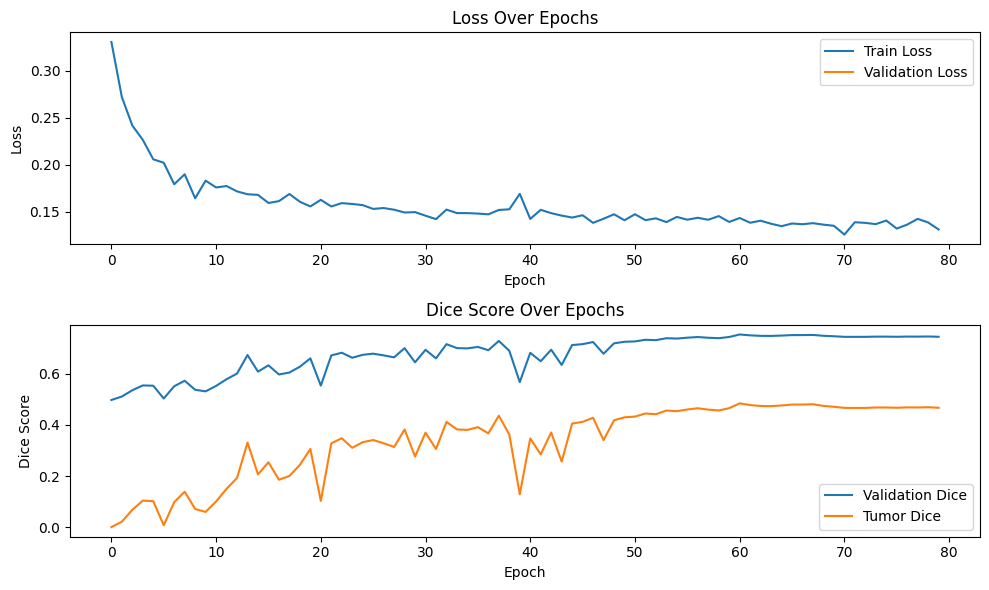

In [10]:
def plot_metrics(metrics):
    plt.figure(figsize=(10, 6))

    # Plot loss
    plt.subplot(2, 1, 1)
    plt.plot(metrics["train_loss"], label="Train Loss")
    plt.plot(metrics["val_loss"], label="Validation Loss")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Dice scores
    plt.subplot(2, 1, 2)
    plt.plot(metrics["val_dice"], label="Validation Dice")
    if "val_dice_per_class" in metrics:
        val_dice_per_class = metrics["val_dice_per_class"]
        if len(val_dice_per_class) > 0:
            plt.plot([c[1] for c in val_dice_per_class], label="Tumor Dice")
    plt.title("Dice Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Load metrics.json for a specific fold
import json
fold_idx = 0  # Replace with the desired fold index
with open(f"{experiment_dir}/fold_{fold_idx+1}/metrics.json", "r") as f:
    metrics = json.load(f)

plot_metrics(metrics)


In [14]:
torch.backends.cudnn.benchmark = False

model.load_state_dict(torch.load(os.path.join(fold_dir,"best_metric_model.pth")))
# Evaluation on Test Data
test_loader = DataLoader(
    CacheDataset(data=fold_splits[fold_idx]["test_files"], transform=test_transforms, cache_rate=0.1, num_workers=4),
    batch_size=batchsize, shuffle=True, num_workers=4
)


Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


In [17]:


import torch
import numpy as np
from monai.transforms import AsDiscrete
from monai.metrics import DiceMetric
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
import os

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Define post transforms and metrics
post_label = AsDiscrete(to_onehot=numberofclasses + 1)
post_pred = AsDiscrete(argmax=True, to_onehot=numberofclasses + 1)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Initialize variables
meandiceperclass = np.zeros([numberofclasses + 1])
test_results = {}

# Set model to evaluation mode
model.eval()


import sys
import os

with torch.no_grad():
    for step, batch in enumerate(test_loader):
        pt_name = fold_split["test_files"][step]["image"].split("/")[-3]
        print("Patient:", pt_name, "/", fold_split["test_files"][step]["image"].split("/")[-1])    

        # Prepare inputs and labels
        val_inputs, val_labels = batch["image"].cuda(), batch["mask"].cuda()
        with torch.cuda.amp.autocast():
            val_outputs = sliding_window_inference(
                inputs=val_inputs,
                roi_size=(64, 64, 64),  # Adjust ROI size as needed
                sw_batch_size=4,
                predictor=model,
                overlap=0.5
            )

        # Post-process outputs and labels
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        val_outputs_list = decollate_batch(val_outputs)
        val_outputs_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

        # Compute Dice score
        dm = dice_metric(y_pred=val_outputs_convert, y=val_labels_convert)
        print(f"Dice Score: {dm[0].tolist()}")

        # Update mean dice per class
        meandiceperclass += dm[0].cpu().numpy()

        # Save results for this patient
        test_results[pt_name] = {
            "dice_scores_per_class": dm[0].tolist()
        }

# Compute average Dice scores across all test cases
meandiceperclass /= (step + 1)
mean_dice_val = dice_metric.aggregate().item()
dice_metric.reset()

# Print final results
print(f"Mean Dice Scores per Class: {meandiceperclass}")
print(f"Overall Mean Dice Score: {mean_dice_val}")


Patient: 2015KIRA / Image.nii.gz
Dice Scores for Patient 2015KIRA: [0.9999609589576721, 0.3531073331832886]
Patient: 2016LUBE / Image.nii.gz
Dice Scores for Patient 2016LUBE: [0.9999626278877258, 0.6647825241088867]
Patient: 2016FAMA / Image.nii.gz
Dice Scores for Patient 2016FAMA: [0.9999833703041077, 0.15835776925086975]
Patient: 2016MCTO / Image.nii.gz
Dice Scores for Patient 2016MCTO: [0.9999776482582092, 0.0]
Patient: 2013SCBO / Image.nii.gz
Dice Scores for Patient 2013SCBO: [0.9999747276306152, 0.7224109768867493]
Patient: 2018NEMI / Image.nii.gz
Dice Scores for Patient 2018NEMI: [0.9999334812164307, 0.16944023966789246]
Patient: 2018CAJO / Image.nii.gz
Dice Scores for Patient 2018CAJO: [0.999966561794281, 0.3798694610595703]
Patient: 2015CHGE / Image.nii.gz
Dice Scores for Patient 2015CHGE: [0.9999819397926331, 0.7115799784660339]
Patient: 2013WAKE / Image.nii.gz
Dice Scores for Patient 2013WAKE: [0.9999945163726807, 0.8180196285247803]
Patient: 2012MUBR / Image.nii.gz
Dice Scor

In [16]:
#DICE SCORES

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

post_label = AsDiscrete(to_onehot=numberofclasses+1)
post_pred = AsDiscrete(argmax=True, to_onehot=numberofclasses+1)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

meandiceperclass = np.zeros([numberofclasses+1])

with torch.no_grad():
    for step, batch in enumerate(test_loader):
        pt_name = fold_split["test_files"][step]["image"].split("/")[-3]
        print("Patient:", pt_name, "/", fold_split["test_files"][step]["image"].split("/")[-1])        
        val_inputs, val_labels = (batch["image"].cuda(), batch["mask"].cuda())
        with torch.cuda.amp.autocast():
            val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.5)
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [
            post_label(val_label_tensor) for val_label_tensor in val_labels_list
        ]
        val_outputs_list = decollate_batch(val_outputs)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        dm = dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        print(dm[0])
        
        meandiceperclass = meandiceperclass + dm[0]
            
    meandiceperclass = meandiceperclass/(step+1)
    print(meandiceperclass)
    mean_dice_val = dice_metric.aggregate().item()
    dice_metric.reset()
    print(mean_dice_val)

#oh2: 
#dice [0.99995105 0.47973852]
#dice 0.739844799041748
#hd [ 0.         96.89730157]
#hd 48.44865417480469
    
#oh3: 
#dice [0.99997076 0.44347209]
#dice 0.7217214107513428
#hd 
#/home/ilkin/anaconda3/envs/pth-v201/lib/python3.11/site-packages/monai/metrics/utils.py:338: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
#[ 0. nan]
#28.4454345703125
    
#oh4
#dice [0.99996147 0.47528535]
#dice 0.737623393535614



Patient: 2015KIRA / Image.nii.gz
metatensor([1.0000, 0.3531], device='cuda:0')
Patient: 2016LUBE / Image.nii.gz
metatensor([1.0000, 0.6648], device='cuda:0')
Patient: 2016FAMA / Image.nii.gz
metatensor([1.0000, 0.1584], device='cuda:0')
Patient: 2016MCTO / Image.nii.gz
metatensor([1.0000, 0.0000], device='cuda:0')
Patient: 2013SCBO / Image.nii.gz
metatensor([1.0000, 0.7224], device='cuda:0')
Patient: 2018NEMI / Image.nii.gz
metatensor([0.9999, 0.1694], device='cuda:0')
Patient: 2018CAJO / Image.nii.gz
metatensor([1.0000, 0.3799], device='cuda:0')
Patient: 2015CHGE / Image.nii.gz
metatensor([1.0000, 0.7116], device='cuda:0')
Patient: 2013WAKE / Image.nii.gz
metatensor([1.0000, 0.8180], device='cuda:0')
Patient: 2012MUBR / Image.nii.gz
metatensor([1.0000, 0.7741], device='cuda:0')
Patient: 2012CHJA / Image.nii.gz
metatensor([1.0000, 0.0000], device='cuda:0')
Patient: 2012DRMA / Image.nii.gz
metatensor([1.0000, 0.4874], device='cuda:0')
Patient: 2017EDRA / Image.nii.gz
metatensor([0.9998,

In [8]:
#HD95 SCORES

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

logFile = open(os.path.join(test_dir, f"{trial_name}_train_out.txt"), "w")

post_label = AsDiscrete(to_onehot=numberofclasses+1)
post_pred = AsDiscrete(argmax=True, to_onehot=numberofclasses+1)
hd_metric = HausdorffDistanceMetric(include_background=True, distance_metric='euclidean', percentile=95)

meanhd95perclass = np.zeros([numberofclasses+1])

with torch.no_grad():
    for step, batch in enumerate(test_loader):
        pt_name = test_files[step]["image"].split("/")[-3]
        print("Patient:", pt_name, "/", test_files[step]["image"].split("/")[-1])     
        val_inputs, val_labels = (batch["image"].cuda(), batch["mask"].cuda())
        with torch.cuda.amp.autocast():
            val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.5)
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [
            post_label(val_label_tensor) for val_label_tensor in val_labels_list
        ]
        val_outputs_list = decollate_batch(val_outputs)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]
        hd = hd_metric(y_pred=val_output_convert, y=val_labels_convert)
        print(hd[0])

        meanhd95perclass = meanhd95perclass + hd[0].cpu().detach().numpy()
            
    meanhd95perclass = meanhd95perclass/(step+1)
    print(meanhd95perclass)
    logFile.close() 
    mean_hd_val = hd_metric.aggregate().item()
    hd_metric.reset()
    print(mean_hd_val)

Patient: 2015KIRA / Image.nii.gz
tensor([ 0.0000, 77.1327], device='cuda:0')
Patient: 2016LUBE / Image.nii.gz
tensor([ 0.0000, 80.7607], device='cuda:0')
Patient: 2016FAMA / Image.nii.gz
tensor([  0.0000, 117.7474], device='cuda:0')
Patient: 2016MCTO / Image.nii.gz
tensor([  0.0000, 102.7988], device='cuda:0')
Patient: 2013SCBO / Image.nii.gz
tensor([  0.0000, 174.1746], device='cuda:0')
Patient: 2018NEMI / Image.nii.gz
tensor([0.0000, 3.7417], device='cuda:0')
Patient: 2018CAJO / Image.nii.gz
tensor([0.0000, 8.3666], device='cuda:0')
Patient: 2015CHGE / Image.nii.gz
tensor([0., 3.], device='cuda:0')
Patient: 2013WAKE / Image.nii.gz
tensor([0.0000, 2.4874], device='cuda:0')
Patient: 2012MUBR / Image.nii.gz
tensor([ 0.0000, 22.8692], device='cuda:0')
Patient: 2012CHJA / Image.nii.gz
tensor([0.0000, 4.1231], device='cuda:0')
Patient: 2012DRMA / Image.nii.gz
tensor([ 0.0000, 67.0059], device='cuda:0')
Patient: 2017EDRA / Image.nii.gz
tensor([  0.0000, 148.3010], device='cuda:0')
Patient: 

In [9]:
#RESULTS

print(f"{step} Test images \nMean DICE: {np.nanmean(mean_dice_val):.3f}\n")

test_results_1 = (f"\nMean DICE: {np.nanmean(meandiceperclass):.3f}\n\nBackground:   {meandiceperclass[0]:.3f}\n")
for i in range(numberofclasses):
    test_results_1 = test_results_1 + str(functions.get_classes(dataset[:-3], seg)[0][i]) + ":    " + str("{0:.3f}".format(meandiceperclass[i+1])) + "\n"
print(test_results_1)

print(f"{step} Test images \nMean HD95: {np.nanmean(mean_hd_val):.3f}\n")

test_results_2 = (f"\nMean HD95: {np.nanmean(meanhd95perclass):.3f}\n\nBackground:   {meanhd95perclass[0]:.3f}\n")
for i in range(numberofclasses):
    test_results_2 = test_results_2 + str(functions.get_classes(dataset[:-3],seg)[0][i]) + ":    " + str("{0:.3f}".format(meanhd95perclass[i+1])) + "\n"
print(test_results_2)

out_path = os.path.join(test_dir, f"{trial_name}_test_out.txt")
# Now, open the file. The 'w' mode will create the file if it doesn't exist.
try:
    with open(out_path, "w") as logFile:
        logFile.write(f"{test_results_1}\n\n{test_results_2}")
        print(f"File written successfully to {out_path}")
except IOError as e:
    print(f"Error writing to file: {e}")

#logFile = open(out_path, "w")
#logFile.write(f"{test_results_1}\n\n{test_results_2}")

logFile.close() 

20 Test images 
Mean DICE: 0.737


Mean DICE: 0.737

Background:   1.000
GTV:    0.475

20 Test images 
Mean HD95: 76.506


Mean HD95: 76.506

Background:   0.000
GTV:    153.012

File written successfully to tests/swinunetr/OH-GLLES-3D/oh2_0_1/oh2_0_1_test_out.txt


In [18]:
import os
import numpy as np
import nibabel as nib
import torch
from monai.inferers import sliding_window_inference

def save_evaluation_results(eval_loader, model, output_dir, device, eval_files, roi_size, overlap=0.5):
    """
    Save evaluation results (image, ground truth, and predictions) as NIfTI files.

    Parameters:
        eval_loader (DataLoader): DataLoader for evaluation dataset.
        model (torch.nn.Module): Trained model.
        output_dir (str): Directory to save evaluation results.
        device (torch.device): Device (CPU/GPU) to use for inference.
        eval_files (list): List of evaluation files.
        roi_size (tuple): ROI size for sliding window inference.
        overlap (float): Overlap for sliding window inference.
    """
    model.eval()
    with torch.no_grad():
        print("\nStarting evaluation and saving results...\n")
        for i, eval_data in enumerate(eval_loader):
            pt_name = eval_files[i]["image"].split("/")[-3]
            print(f"Processing Patient: {pt_name}")

            # Load the original NIfTI file to get the affine matrix
            original_nifti = nib.load(eval_files[i]["image"])
            affine = original_nifti.affine

            # Perform sliding window inference
            eval_inputs = eval_data["image"].to(device)
            eval_outputs = sliding_window_inference(
                eval_inputs, roi_size, sw_batch_size=4, predictor=model, overlap=overlap
            )

            # Convert tensors to numpy arrays
            image = eval_data["image"][0, 0].cpu().numpy()
            mask = eval_data["mask"][0, 0].cpu().numpy()
            predicted = torch.argmax(eval_outputs, dim=1).detach().cpu().numpy()[0]

            # Create the output directory for this patient
            patient_output_dir = os.path.join(output_dir, pt_name)
            os.makedirs(patient_output_dir, exist_ok=True)

            # Save as NIfTI files using the original affine matrix
            nib.save(nib.Nifti1Image(image, affine), os.path.join(patient_output_dir, f"{pt_name}_image.nii"))
            nib.save(nib.Nifti1Image(mask, affine), os.path.join(patient_output_dir, f"{pt_name}_mask.nii"))
            nib.save(nib.Nifti1Image(predicted.astype(np.int16), affine), os.path.join(patient_output_dir, f"{pt_name}_predicted.nii"))

            print(f"Results saved for {pt_name} at {patient_output_dir}")

# Example usage
save_evaluation_results(
    eval_loader=test_loader,  # Test DataLoader
    model=model,              # Trained model
    output_dir=os.path.join(experiment_dir, f"fold_{fold_idx+1}", "evaluation_results"),  # Directory for saving results
    device=device,            # CPU or GPU device
    eval_files=fold_split["test_files"],    # Test file paths
    roi_size=(64, 64, 64),    # ROI size for sliding window
    overlap=0.5               # Overlap for sliding window
)



Starting evaluation and saving results...

Processing Patient: 2015KIRA
Results saved for 2015KIRA at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s1/fold_1/evaluation_results/2015KIRA
Processing Patient: 2016LUBE
Results saved for 2016LUBE at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s1/fold_1/evaluation_results/2016LUBE
Processing Patient: 2016FAMA
Results saved for 2016FAMA at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s1/fold_1/evaluation_results/2016FAMA
Processing Patient: 2016MCTO
Results saved for 2016MCTO at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s1/fold_1/evaluation_results/2016MCTO
Processing Patient: 2013SCBO
Results saved for 2013SCBO at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s1/fold_1/evaluation_results/2013SCBO
Processing Patient: 2018NEMI
Results saved for 2018NEMI at /home/ilkin/Documents/2024PHD/rep/swinunetr/tests/OH-GLLES-3D/s1/fold_1/evaluation_results/2018NEMI
Pr